In [1]:
import numpy as np
import scipy.io as sio
import berkeley_util as butil 
from scipy.spatial.distance import cdist
import pandas as pd
import matplotlib.pyplot as plt
import json
import plotly.express as px
from scipy import interpolate

In [2]:
def loading(ID,walkNum,walktype):
    
    dataset = []
    for x in walkNum:
        loc = '/N/project/berkeley_walking/BerkeleyData/berkeley_json'
        with open(f'{loc}/s{str(ID)}_{x}_{str(walktype)}_allWalks.json', "r") as f:
                data = json.load(f)
        dataset.append(data)
    return dataset


In [3]:
def get_fixations(dataset):

    f_start = []
    f_stop = []
    fixations_df_list = []
    gaze_df_list = []
    for data in dataset:
        
        framerate = data['framerate']
        frames,time= np.array(data['frames']),np.array(data['syncedUnixTime'])
        time = time -time[0]
        fixation = np.array(data['rEye_blinks'], dtype = bool)
        theta = np.array(data['rEye_theta'])
        theta_fix = np.array(data['rEye_theta'])
        theta_fix[fixation] = np.nan
        gaze_df = pd.DataFrame({ 'Frames': frames, 'Time': time, 'Theta': theta,
                             'ThetaFix': theta_fix})
        fixations_df = pd.DataFrame({ 'Frames': frames, 'Time': time, 'Theta': theta,
                             'ThetaFix': theta_fix})
        

        fixations_df = fixations_df.dropna()
        fixations_df['TimeDiffPrev'],   fixations_df['TimeDiffFol'] = fixations_df['Time'].diff(), fixations_df['Time'].diff(periods=-1)
        fix_stop, fix_start = fixations_df.loc[fixations_df['TimeDiffPrev'] > 0.009], fixations_df.loc[fixations_df['TimeDiffFol'] < -0.009]
        fixations_df_list.append(fixations_df)
        gaze_df['isFixated'] = ~gaze_df['ThetaFix'].isna()

        gaze_df_list.append(gaze_df)
        f_start.append(fix_start)
        f_stop.append(fix_stop)
        
    return fixations_df_list, f_stop, f_start, gaze_df_list

In [4]:
def get_steps(dataset):

    steps_df = []
    for data in dataset:
        
        framerate = data['framerate']
        steps = np.array(data['steps_HS_TO_StanceLeg_XYZ'])
        step_start, step_end = steps[:,0].astype(int), steps[:,1].astype(int)
        step_start_time, step_end_time = step_start / framerate, step_end / framerate
        step_frames = steps[:,0:2].astype(int)
        step_time = step_frames.T / framerate

        steps = pd.DataFrame({'FrameStart': steps[:,0], 'FrameEnd': steps[:,1], 'Foot':steps[:,2],
                         'X': steps[:,3],  'Y': steps[:,4],  'Z' :steps[:,5]})

        steps['StartTime'],steps['EndTime'] = step_start_time, step_end_time
        steps_df.append(steps)

    return steps_df

In [5]:
def find_closest_hs(steps_df, stop, start):

    closest_hs_df = []
    closest_hs = []
    reshaped_start = []
    reshaped_stop = []
    for steps,sp,st in zip(steps_df,stop,start):
        footfalls,f_stop, f_start = np.array(steps['StartTime']),np.array(sp['Time']), np.array(st['Time'])
        footfalls, f_stop, f_start  = footfalls.reshape(-1,1), f_stop.reshape(-1,1), f_start.reshape(-1,1)
        reshaped_start.append(f_start)
        reshaped_stop.append(f_stop)

        from sklearn.neighbors import NearestNeighbors
        X = footfalls
        Start = f_start

        neigh = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(X)
        start_distances, start_indices = neigh.kneighbors(Start)
        startNearest = np.array(start_indices)

        closest_heelstrike_time = footfalls[startNearest]
        closest_heelstrike_time = closest_heelstrike_time[:,0]
        closest_hs.append(closest_heelstrike_time)
        closest = pd.DataFrame(closest_heelstrike_time, columns = ['TimeNearFixStart'])
        closest['IndexNearFixStart'] = startNearest
        closest_hs_df.append(closest)
        
    return closest_hs, reshaped_stop, reshaped_start, closest_hs_df

In [6]:
def calc_rel_fix(closest_hs, reshaped_stop, reshaped_start):
    
    rel_start = []
    rel_stop = []
    
    for x,st,sp in zip(closest_hs,reshaped_start, reshaped_stop):
            rstart = st - x
            rstop = sp - x
            rel_start.append(rstart)
            rel_stop.append(rstop)
        
    return rel_start, rel_stop


def time_diff(steps_df):
    
    new_steps_df = []
    for steps in steps_df:
        steps['nextdiff'] = steps['StartTime'].diff(-1).abs()
        steps['prevdiff'] = steps['StartTime'].diff()
        new_steps_df.append(steps)
        
    return new_steps_df

In [7]:
def get_next_prev_current(steps_df):
    prev = []
    current = []
    next = []
    for x in steps_df:
        for index,step in x.iterrows():
            if (index > 0) and (index < x.shape[0] - 1):
                prev_step_time = x.StartTime[index - 1]
                current_step_time = x.StartTime[index]
                next_step_time = x.StartTime[index + 1]

        prev.append(prev_step_time)
        current.append(current_step_time)
        next.append(next_step_time)
            
    return prev, current, next

In [8]:
def calculate_interpolated_fixation_vector(gaze_list,prev,current,next):
    fix_list = []
    for gaze,one,two,three in zip (gaze_list,prev,current,next):
        time, isFixated = gaze['Time'], gaze['isFixated'] 
        idx = (time >= one) &  (time <= two)
        idx1 = (time >= two) &  (time <= three)
        x,x1 = time[idx], time[idx1]
        y,y1 = isFixated[idx], isFixated[idx1]
        f = interpolate.interp1d(x, y, kind = 'nearest', bounds_error = False, fill_value = 'extrapolate')
        f1 = interpolate.interp1d(x1, y1, kind = 'nearest', bounds_error = False, fill_value = 'extrapolate')

        xnew = np.linspace(one, two, 75)
        xnew1 = np.linspace(two, three, 75)
        
        segment_one = f(xnew)
        segment_two = f1(xnew1)
        fix = np.hstack((segment_one,segment_two[1:]))
        fix_list.append(fix)

    return fix_list

In [9]:
def norm(rel_start, rel_stop,steps_df_new, closest_hs_df):
    
    norm_st = []
    for x,i,s,hs in zip(rel_start,range(len(rel_start)),steps_df_new,closest_hs_df):
        y = hs['IndexNearFixStart'][i]
        if y==0 and i==0:
            norm = x / hs['TimeNearFixStart'][1] - hs['TimeNearFixStart'][i]
        elif x.all() <=0:
            norm = x / s['prevdiff'][y]
        elif x.all() >=0:
            norm = x/ s['nextdiff'][y]
            
            
        norm_st.append(norm)
    
        

    norm_sp = []
    for x,i,s,hs in zip(rel_stop,range(len(rel_stop)),steps_df_new,closest_hs_df):
        y = hs['IndexNearFixStart'][i]
        if y==0 and i==0:
            norm = x / hs['TimeNearFixStart'][1] - hs['TimeNearFixStart'][i]
        elif x.all() <=0:
            norm = x / s['prevdiff'][y]
        elif x.all() >=0:
            norm = x/ s['nextdiff'][y]

        norm_sp.append(norm)
    
    return norm_st, norm_sp

In [10]:
def making_dataframes(relstart, relstop, normstart, normstop):
    df_list = []
    for rel_st, rel_sp, n_st, n_sp in zip(relstart, relstop, normstart, normstop):
        rel_st, rel_sp, n_st, n_sp = np.array(rel_st),np.array(rel_sp), np.array(n_st),  np.array(n_sp)
        rel_st, rel_sp = rel_st[:,0], rel_sp[:,0]

        df = pd.DataFrame(rel_st, columns=['RelStart'])
        df['RelStop'],df['NormStart'], df['NormStop'] = rel_sp, n_st, n_sp 
        df_list.append(df)
        
    return df_list
        
        

In [22]:
fix_rocks = []
rocks_df_list = []

for x in range(3,11):
    walkNum = butil.find_walks_with_type(x,'rocks')
    dataset = loading(x,walkNum,'rocks')
    fixations_df_list, f_stop, f_start, gaze_df_list = get_fixations(dataset)
    steps_df = get_steps(dataset)
    print([s.shape[0] for s in steps_df])
    
    prev,current,next = get_next_prev_current(steps_df)
    fix = calculate_interpolated_fixation_vector(gaze_df_list,prev,current,next)
    fix_array = np.stack(fix)
    fix_rocks.append(fix_array)
    
    closest_hs, stop_reshaped, start_reshaped, closest_hs_df = find_closest_hs(steps_df,f_stop, f_start )
    rel_start,rel_stop = calc_rel_fix(closest_hs, stop_reshaped, start_reshaped)
    steps_df_new = time_diff(steps_df)
    norm_st, norm_sp = norm(rel_start,rel_stop,steps_df_new,closest_hs_df)
    
    df = making_dataframes(rel_start,rel_stop, norm_st, norm_sp)
    df_new = pd.concat(df)
    rocks_df_list.append(df_new)
    
    


[25, 46, 24, 23, 41, 46, 29, 37, 45, 98, 48]
[33, 46, 45, 43, 104, 27, 22, 52, 13, 104]
[13, 14, 73, 77, 25, 83, 9, 78]
[138, 28, 34, 129, 60, 21, 34, 38, 15, 123]
[23, 110, 32, 113, 16, 24, 116, 103]
[97, 24, 88, 22, 28, 90, 20, 105]
[119, 126, 114, 27, 128, 31, 23, 35]
[35, 39, 26, 46, 32, 30, 49, 46, 46, 24, 44, 36]


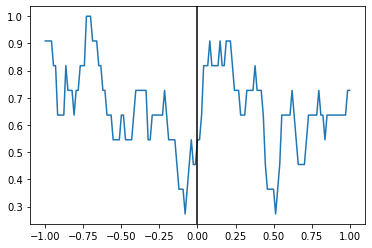

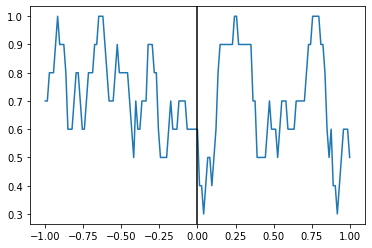

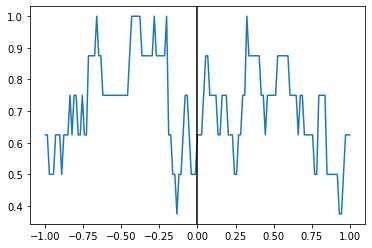

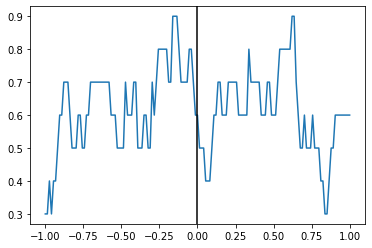

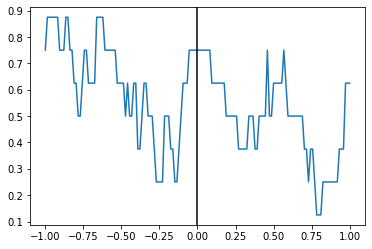

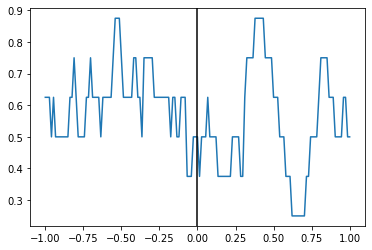

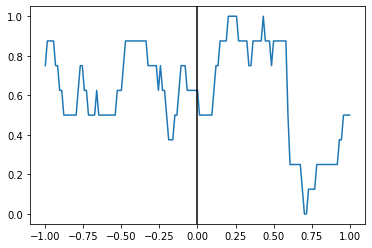

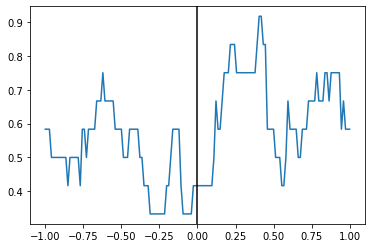

In [12]:
for fix in fix_rocks:
    plt.plot(np.linspace(-1,1,149), fix.mean(axis=0))
    plt.axvline(x=0, color='k')
    plt.show()

(75, 149)

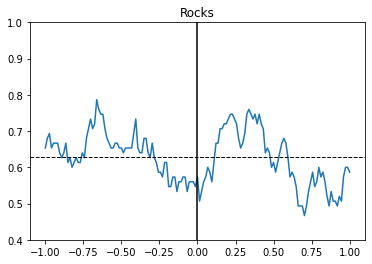

In [19]:
fix_rocks_pooled = np.vstack(fix_rocks)
plt.plot(np.linspace(-1,1,149), fix_rocks_pooled.mean(axis=0))
plt.axhline(y=fix_rocks_pooled.mean(),linestyle='--',color='k',linewidth=1)

plt.axvline(x=0, color='k')
plt.title('Rocks')
plt.ylim(0.4,1)
plt.savefig('rocks.png')
fix_rocks_pooled.shape

In [17]:
fix_medium = []
medium_df_list = []

for x in range(3,11):
    walkNum = butil.find_walks_with_type(x,'medium')
    dataset = loading(x,walkNum,'medium')
    fixations_df_list, f_stop, f_start, gaze_df_list = get_fixations(dataset)
    steps_df = get_steps(dataset)
    
    prev,current,next = get_next_prev_current(steps_df)
    fix = calculate_interpolated_fixation_vector(gaze_df_list,prev,current,next)
    fix_array = np.stack(fix)
    fix_medium.append(fix_array)
    
    closest_hs, stop_reshaped, start_reshaped, closest_hs_df = find_closest_hs(steps_df,f_stop, f_start )
    rel_start,rel_stop = calc_rel_fix(closest_hs, stop_reshaped, start_reshaped)
    steps_df_new = time_diff(steps_df)
    norm_st, norm_sp = norm(rel_start,rel_stop,steps_df_new,closest_hs_df)
    
    df = making_dataframes(rel_start,rel_stop, norm_st, norm_sp)
    df_new = pd.concat(df)
    medium_df_list.append(df_new)

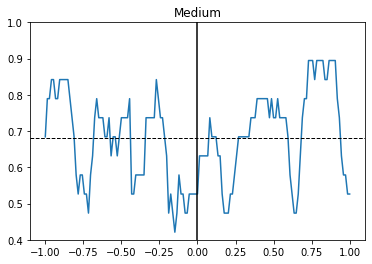

In [58]:
fix_medium_pooled = np.vstack(fix_medium)
plt.plot(np.linspace(-1,1,149), fix_medium_pooled.mean(axis=0))
plt.axhline(y=fix_medium_pooled.mean(),linestyle='--',color='k',linewidth=1)
plt.axvline(x=0, color='k')
plt.ylim(0.4,1)
plt.title('Medium')
plt.savefig('medium.png')

In [23]:
fix_flat = []
flat_df_list = []

for x in range(3,11):
    walkNum = butil.find_walks_with_type(x,'flat')
    dataset = loading(x,walkNum,'flat')
    fixations_df_list, f_stop, f_start, gaze_df_list = get_fixations(dataset)
    steps_df = get_steps(dataset)
    print([s.shape[0] for s in steps_df])
    prev,current,next = get_next_prev_current(steps_df)
    fix = calculate_interpolated_fixation_vector(gaze_df_list,prev,current,next)
    fix_array = np.stack(fix)
    fix_flat.append(fix_array)
    
    
    
    closest_hs, stop_reshaped, start_reshaped, closest_hs_df = find_closest_hs(steps_df,f_stop, f_start )
    rel_start,rel_stop = calc_rel_fix(closest_hs, stop_reshaped, start_reshaped)
    steps_df_new = time_diff(steps_df)
    norm_st, norm_sp = norm(rel_start,rel_stop,steps_df_new,closest_hs_df)
    
    df = making_dataframes(rel_start,rel_stop, norm_st, norm_sp)
    df_new = pd.concat(df)
    flat_df_list.append(df_new)

[47, 34, 39, 109, 60]
[106, 39, 103, 30]
[27, 80, 21, 63, 25]
[41, 39, 122, 114]
[126, 121, 46, 43]
[41, 53, 111, 109]
[46, 117, 40, 126]
[26, 103, 44, 103]


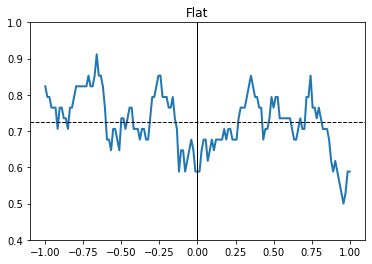

In [57]:
fix_flat_pooled = np.vstack(fix_flat)
plt.plot(np.linspace(-1,1,149), fix_flat_pooled.mean(axis=0),linewidth=2)
plt.axvline(x=0, color='k',linewidth=1)
plt.axhline(y=fix_flat_pooled.mean(),linestyle='--',color='k',linewidth=1)
plt.ylim(0.4,1)
plt.title('Flat')
plt.savefig('flat.png')

In [19]:
rocks_pooled = pd.concat(rocks_df_list)
medium_pooled = pd.concat(medium_df_list)
flat_pooled = pd.concat(flat_df_list)

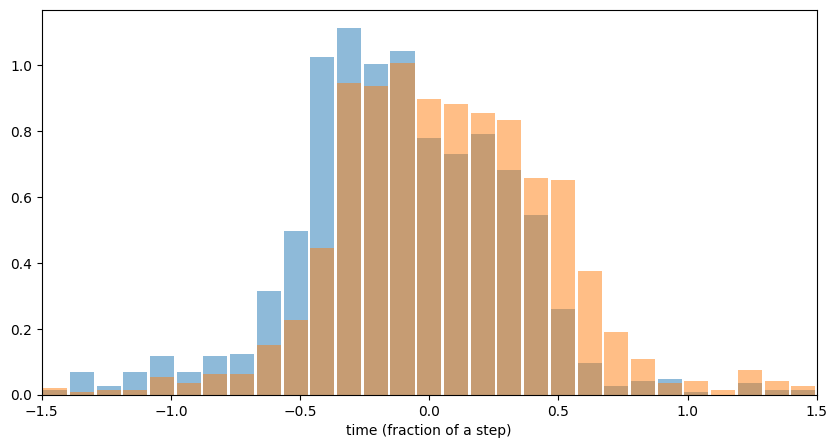

In [22]:
plt.figure(figsize=(10,5))
nBins = 30;

plt.subplot()
plt.hist(medium_pooled['NormStart'],bins=np.linspace(-1.5,1.5,num=nBins),density=True,rwidth=.9,alpha=.5)
plt.hist(medium_pooled['NormStop'],bins=np.linspace(-1.5,1.5,num=nBins),density=True,rwidth=.9,alpha=.5)

plt.xlabel('time (fraction of a step)')
plt.xlim(-1.5, 1.5)
plt.savefig('densityplot.png')

In [ ]:
walkNum = butil.find_walks_with_type(3,'rocks')
dataset = loading(3,walkNum,'rocks')
fixations_df_list, f_stop, f_start, gaze_df_list = get_fixations(dataset)
steps_df = get_steps(dataset)
closest_hs, stop_reshaped, start_reshaped, closest_hs_df = find_closest_hs(steps_df,f_stop, f_start )
rel_start,rel_stop = calc_rel_fix(closest_hs, stop_reshaped, start_reshaped)
steps_df_new = time_diff(steps_df)
norm_st, norm_sp = norm(rel_start,rel_stop,steps_df_new,closest_hs_df)
df_3_rocks = making_dataframes(rel_start,rel_stop, norm_st, norm_sp)

for x in df_3_rocks:
    plt.hist(x['NormStart'],bins=bins)
    plt.show()

In [28]:
walkNum = butil.find_walks_with_type(3,'flat')
dataset = loading(3,walkNum,'flat')
fixations_df_list, f_stop, f_start, gaze_df_list = get_fixations(dataset)
steps_df = get_steps(dataset)
prev,current,next = get_next_prev_current(steps_df)
fix = calculate_interpolated_fixation_vector(gaze_df_list,prev,current,next)


In [33]:
fix[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
walkNum = butil.find_walks_with_type(4,'rocks')
dataset = loading(4,walkNum,'rocks')
fixations_df_list, f_stop, f_start, gaze_df_list = get_fixations(dataset)
steps_df = get_steps(dataset)
closest_hs, stop_reshaped, start_reshaped, closest_hs_df = find_closest_hs(steps_df,f_stop, f_start )
rel_start,rel_stop = calc_rel_fix(closest_hs, stop_reshaped, start_reshaped)
steps_df_new = time_diff(steps_df)
norm_st, norm_sp = norm(rel_start,rel_stop,steps_df_new,closest_hs_df)
df_4_rocks = making_dataframes(rel_start,rel_stop, norm_st, norm_sp)

for x in df_4_rocks:
    plt.hist(x['RelStart'],bins=bins)
    plt.show()

In [ ]:
walkNum = butil.find_walks_with_type(4,'flat')
dataset = loading(4,walkNum,'flat')
fixations_df_list, f_stop, f_start, gaze_df_list = get_fixations(dataset)
steps_df = get_steps(dataset)
closest_hs, stop_reshaped, start_reshaped, closest_hs_df = find_closest_hs(steps_df,f_stop, f_start )
rel_start,rel_stop = calc_rel_fix(closest_hs, stop_reshaped, start_reshaped)
steps_df_new = time_diff(steps_df)
norm_st, norm_sp = norm(rel_start,rel_stop,steps_df_new,closest_hs_df)
df_4_flat = making_dataframes(rel_start,rel_stop, norm_st, norm_sp)

for x in df_4_flat:
    plt.hist(x['NormStart'],bins=bins)
    plt.show()

In [ ]:
nBins = 30;

for x in rocks_df_list:
    plt.subplot()
    plt.hist(x['NormStart'],bins=np.linspace(-1.5,1.5,num=nBins),density=True,rwidth=.9,alpha=.5)
    plt.xlabel('time (fraction of a step)')
    plt.xlim(-1.5, 1.5)
    plt.show()


In [ ]:
plt.figure(figsize=(45,15))
nBins = 30;

plt.subplot(1,3,1)

plt.hist(flat_pooled['NormStart'],bins=np.linspace(-1.5,1.5,num=nBins),density=True)
plt.hist(medium_pooled['NormStart'],bins=np.linspace(-1.5,1.5,num=nBins),density=True)
plt.hist(rocks_pooled['NormStart'],bins=np.linspace(-1.5,1.5,num=nBins),density=True)
plt.xlabel('Fraction of a Step')


plt.subplot(1,3,2)
plt.hist(flat_pooled['NormStop'],bins=np.linspace(-1.5,1.5,num=nBins),density=True)
plt.hist(medium_pooled['NormStop'],bins=np.linspace(-1.5,1.5,num=nBins),density=True)
plt.hist(rocks_pooled['NormStop'],bins=np.linspace(-1.5,1.5,num=nBins),density=True)
plt.xlabel('Fraction of a Second')

plt.subplot(1,3,3)
plt.hist(rocks_pooled['NormStart'],bins=np.linspace(-1.5,1.5,num=nBins),density=True)
plt.hist(rocks_pooled['NormStop'],bins=np.linspace(-1.5,1.5,num=nBins),density=True)

plt.xlabel('Fraction of a Second')
plt.xlim(-1.5, 1.5)
plt.title('All Rocks Walks Normalized')
plt.savefig('densityplots')

print()

In [ ]:
plt.figure(figsize=(45,15))
bins = np.linspace(-1.5,1.5,num=30)

plt.subplot(2,3,1)
plt.hist(flat_pooled['RelStart'],bins=bins)
plt.title('All Flat Rel Start')
plt.ylabel('frequency')
plt.xlabel('time(s)')

plt.subplot(2,3,2)
plt.hist(medium_pooled['RelStart'],bins=bins)
plt.title('All Medium Rel Start')
plt.ylabel('frequency')
plt.xlabel('time(s)')


plt.subplot(2,3,3)
plt.hist(rocks_pooled['RelStart'],bins=bins)
plt.title('All Rocks Rel Start')
plt.ylabel('frequency')
plt.xlabel('time(s)')


plt.subplot(2,3,4)
plt.hist(flat_pooled['RelStop'],bins=bins)
plt.title('All Flat Rel Stop')
plt.ylabel('frequency')
plt.xlabel('time(s)')

plt.subplot(2,3,5)
plt.hist(medium_pooled['RelStop'],bins=bins)
plt.title('All Medium Rel Stop')
plt.ylabel('frequency')
plt.xlabel('time(s)')


plt.subplot(2,3,6)
plt.hist(rocks_pooled['RelStop'],bins=bins)
plt.title('All Rocks Rel Stop')
plt.ylabel('frequency')
plt.xlabel('time(s)')

plt.savefig('hists.png')





In [ ]:
plt.hist(flat_pooled['RelStart'],bins=bins)
plt.title('All Flat Rel Start')
plt.ylabel('frequency')
plt.xlabel('time(s)')
plt.savefig('flat.png')


In [ ]:
plt.hist(medium_pooled['RelStart'],bins=bins)
plt.title('All Medium Rel Start')
plt.ylabel('frequency')
plt.xlabel('time(s)')
plt.savefig('medium.png')

In [ ]:
plt.hist(rocks_pooled['RelStart'],bins=bins)
plt.title('All Rocks Rel Start')
plt.ylabel('frequency')
plt.xlabel('time(s)')
plt.savefig('rocks.png')